## Imports

In [14]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Loading Data

In [2]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df_har = pd.read_csv('./WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None, names = columns,on_bad_lines='skip')

In [3]:
df_har = df_har.dropna()
df_har.shape

(1086465, 6)

In [4]:
# transforming the z-axis to float
df_har['z-axis'] = df_har['z-axis'].str.replace(';', '')
df_har['z-axis'] = df_har['z-axis'].apply(lambda x:float(x))

In [5]:
# drop rows where timestamp is 0
df = df_har[df_har['timestamp'] != 0]

In [6]:
# arrange data in ascending order of user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

In [7]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


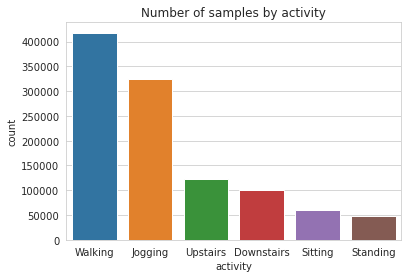

In [11]:
sns.set_style("whitegrid")
sns.countplot(x = 'activity', data = df)
plt.title('Number of samples by activity')
plt.show()

### Data Preparation

In [12]:
random_seed = 42   
n_time_steps = 50 
n_features = 3 
step = 10 
n_classes = 6 
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015

In [15]:
segments = []
labels = []

for i in range(0,  df.shape[0]- n_time_steps, step):  

    xs = df['x-axis'].values[i: i + 50]

    ys = df['y-axis'].values[i: i + 50]

    zs = df['z-axis'].values[i: i + 50]

    label = stats.mode(df['activity'][i: i + 50])[0][0]

    segments.append([xs, ys, zs])

    labels.append(label)

#reshape the segments which is (list of arrays) to a list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [16]:
reshaped_segments.shape

(107358, 50, 3)

### Train-Test Split

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)

### Model Architecture

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

2022-09-13 10:00:59.381690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-13 10:00:59.702828: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-13 10:00:59.712111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-13 10:00:59.712139: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [20]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5)) 
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-09-13 10:16:28.934997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-13 10:16:28.935061: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-13 10:16:28.935105: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (haider): /proc/driver/nvidia/version does not exist
2022-09-13 10:16:28.935797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)

Epoch 1/50
68/68 [==============================] - 29s 384ms/step - loss: 0.9184 - accuracy: 0.6738 - val_loss: 0.5727 - val_accuracy: 0.7979
Epoch 2/50
68/68 [==============================] - 25s 369ms/step - loss: 0.5359 - accuracy: 0.8128 - val_loss: 0.4755 - val_accuracy: 0.8259
Epoch 3/50
68/68 [==============================] - 25s 371ms/step - loss: 0.4770 - accuracy: 0.8287 - val_loss: 0.4510 - val_accuracy: 0.8326
Epoch 4/50
68/68 [==============================] - 25s 369ms/step - loss: 0.4303 - accuracy: 0.8444 - val_loss: 0.4010 - val_accuracy: 0.8496
Epoch 5/50
68/68 [==============================] - 25s 370ms/step - loss: 0.3962 - accuracy: 0.8544 - val_loss: 0.3873 - val_accuracy: 0.8540
Epoch 6/50
68/68 [==============================] - 25s 368ms/step - loss: 0.3679 - accuracy: 0.8645 - val_loss: 0.3528 - val_accuracy: 0.8681
Epoch 7/50
68/68 [==============================] - 25s 368ms/step - loss: 0.3426 - accuracy: 0.8742 - val_loss: 0.3302 - val_accuracy: 0.8787

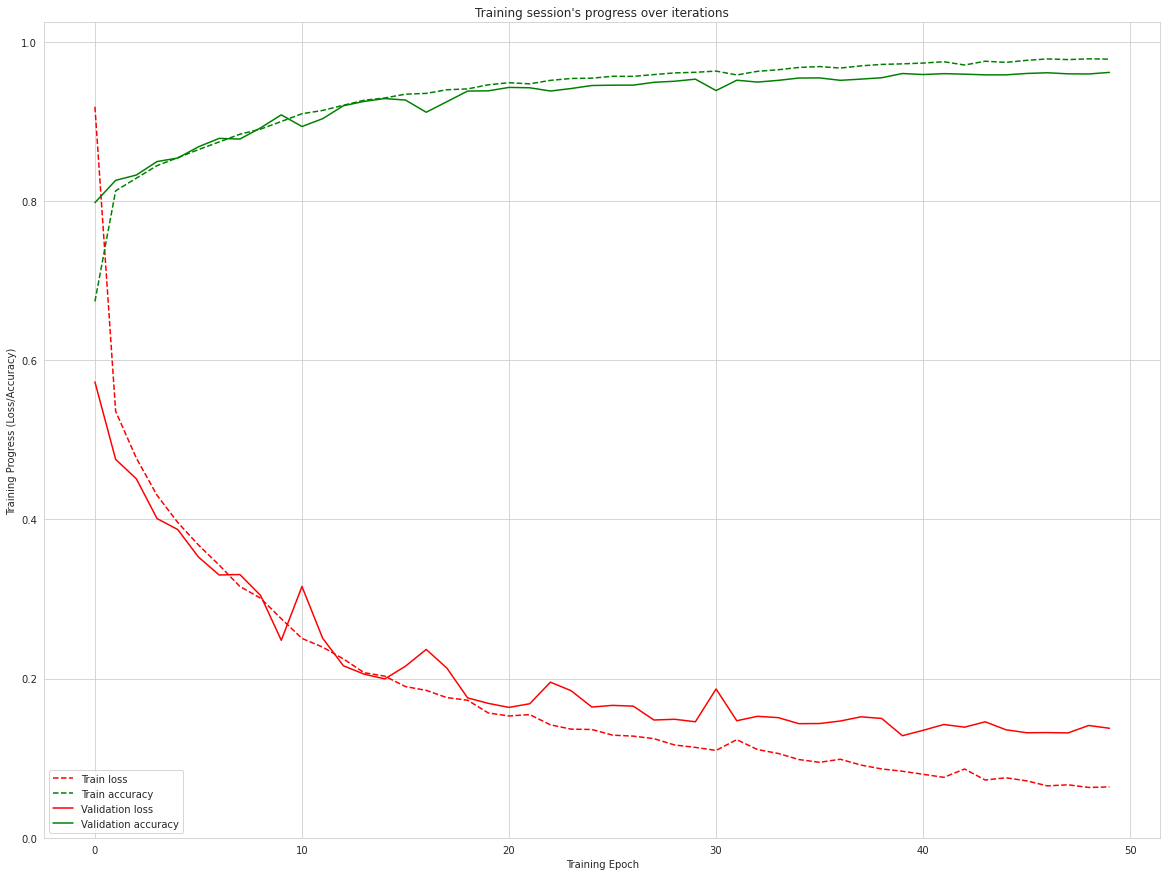

In [26]:
plt.figure(figsize=(20,15))
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()